# MainQuest
## (1) 프로젝트 : 폐렴 진단기 성능개선

루브릭</br>
<span style="color: #808080">아래의 기준을 바탕으로 프로젝트를 평가합니다.</span></br>

<table>
    <tr>
        <td align=center><b>평가문항</b></td>
        <td align=center><b>상세기준</b></td>
    </tr>
    <tr>
        <td>1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.</td>
        <td>모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.</td>
    </tr>
    <tr>
        <td>2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.</td>
        <td width='360'>regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.</td>
    </tr>
    <tr>
        <td>3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.</td>
        <td>Accuracy 기준 85%에 도달하였다.</td>
    </tr>
</table>

기존 학습에서 만들었던 X-RAY 사진 판독 폐렴 진단기의 성능 평가를 위한 개선 시도를 해보자.</br>

In [1]:
# 사용할 모듈 추가
## 주요 라이브러리 버전 확인
# 사용할 패키지 모듈
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.6.0


## Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [2]:
## 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 기존 훈련 횟수, 소그룹 분류크기(BATCH_SIZE) 대비 2배 설정 후 테스트
BATCH_SIZE = 32
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행</br>
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않으므로 이를 극복할 수 있는 방법을 고민해보기</br>

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.</br>
그래서 augmentation 도입은 신중해야 합니다.</br>

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.</br>

```python
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
```

In [3]:
# 설정한 경로에서 데이터 읽기 (train, test, val)
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)


print(f"TRAIN 데이터 개수: {len(train_filenames)}")
print(f"TEST 데이터 개수: {len(test_filenames)}")
print(f"VAL 데이터 개수: {len(val_filenames)}")

TRAIN 데이터 개수: 5216
TEST 데이터 개수: 624
VAL 데이터 개수: 16


In [4]:
# test, val 데이터 모으기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모인 데이터를 8:2 비율로 분리 (train : val = 8 : 2)
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 분리가 끝난 test, val 데이터 개수 확인해보기
print(f"TRAIN 데이터 개수: {len(train_filenames)}")
print(f"VAL 데이터 개수: {len(val_filenames)}")

TRAIN 데이터 개수: 4185
VAL 데이터 개수: 1047


In [5]:
# 훈련 데이터 중에서 정상, 폐렴 이미지 1건씩 확인하기
## 확인하면서 파일 경로를 같이 출력하여 패턴으로 활용할 수 있는게 있을지 같이 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
## 딥러닝 모델 학습을 위한 tf.data 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
## 파일 경로의 패턴을 활용하여 라벨 데이터 생성하는 함수 선언
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
    # 폐렴이면 양성(True), 노말이면 음성(False)
    return parts[-2] == "PNEUMONIA"

우선 이미지를 동일한 사이즈(`180, 180`)으로 설정부터..

In [8]:
# 이미지 사이즈 통일시키는 함수 선언; decode_img()
## 파일 경로를 읽어 이미지 사이즈 통일시키는 함수 선언; process_path()

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
# train, validation 데이터셋의 이미지 크기를 균일화
# 위에서 설정해둔 AUTOTUNE 변수를 이용하면 데이터 처리 속도 증가
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
## (train data)의 이미지 크기와 라벨 확인
## train_ds.take(1) : 하나의 데이터만 가져옴
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
## test 데이터셋 이미지 균일화
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


In [12]:
## (test data)의 이미지 크기와 라벨 확인
## test_ds.take(1) : 하나의 데이터만 가져옴
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 180, 180, 3)
Label:  [ True  True  True False  True  True False  True False  True  True  True
  True False False  True  True False False False  True False False False
 False False  True  True  True False False  True]


Train, Test 데이터셋의 크기는 균일화 했으니, 이미지를 읽어서 학습할 수 있게 하는 전처리 함수를 작성하기</br>

In [13]:
# 데이터 시각화에서 augment 미적용 케이스로 출력해볼 예정
## 이미지를 읽어 학습을 위한 datastream으로 처리해주는 함수 선언
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # shuffle(): 고정 크기 버퍼 유지하면서 해당 버퍼에서 무작위로 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat(): 자동으로 데이터셋을 학습 epoch마다 불러오게 해줌
    ds = ds.repeat()
    # batch() : 설정한 BATCH_SIZE만큼 데이터를 그룹화
    ds = ds.batch(BATCH_SIZE)
    # prefetch() : 학습 데이터를 나눠서 읽어옴
    ## ex: 첫 번째 데이터를 GPU에서 학습; 두 번째 데이터는 CPU에서 준비
    ## resource의 유휴 상태를 줄일 수 있다.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 실습처럼 train 데이터에 대해서만 확인해보려고 함
not_augment_train_ds = prepare_for_training(train_ds)

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# 실질적으로 학습이 될 좌우반전된 이미지들
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인</br>
만약 augmentation을 시도했다면 이후 실습 코드에 있는 `show_batch()` 함수를 통해
실제로 좌우 반전 등이 제대로 처리되었는지 확인</br>

데이터 시각화를 위한 함수(`show_batch()`) 선언

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

실습과 동일한 데이터셋 이미지 시각화</br>
- 위 과정에서 선언한 `not_augment_train_ds` 사용

`BATCH_SIZE`가 실습 대비 두배 많게 작성되어서 결과가 조금 더 길게 나옴

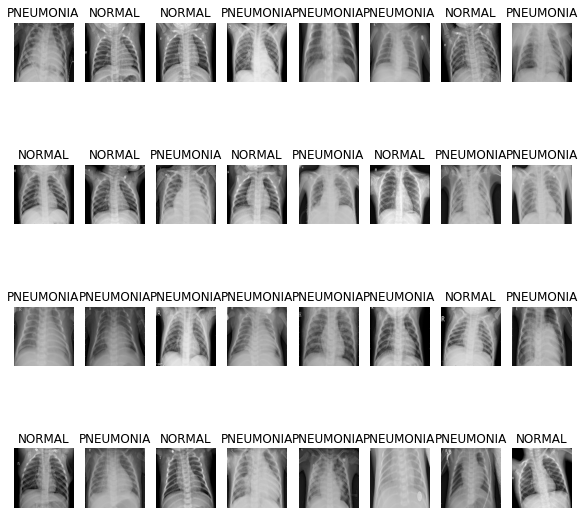

In [16]:
image_batch, label_batch = next(iter(not_augment_train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

좌우 반전시킨 데이터셋 이미지 시각화</br>
- 위 과정에서 선언한 `train_ds` 사용

`BATCH_SIZE`가 실습 대비 두배 많게 작성되어서 결과가 조금 더 길게 나옴

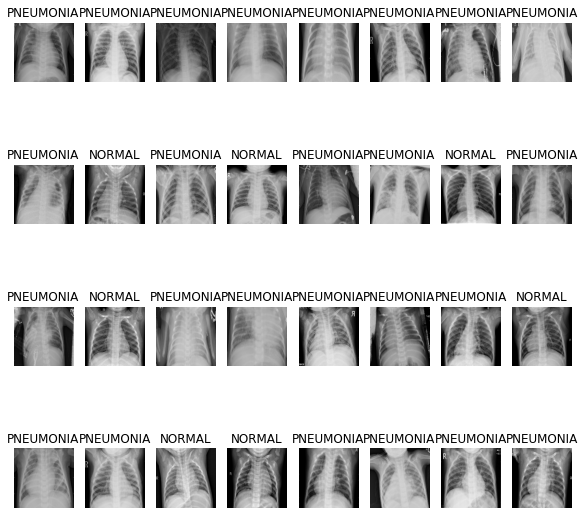

In [17]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

3x3 CNN
BatchNormalization
로 구성되어 있습니다.

In [18]:
def conv_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [19]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [20]:
def build_model():
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    # Define size of sub-blocks and initial filter size
    block_layers = [2, 2, 2, 2]
    filter_size = 64
    
    # Step 3 Add the Resnet Blocks
    for i in range(1, len(block_layers)):
        # One Residual/Convolutional Block followed by Identity blocks
        # The filter size will go on increasing by a factor of 2
        filter_size = filter_size*2
        x = conv_block(x, filter_size)
        for j in range(block_layers[i] - 1):
            x = identity_block(x, filter_size)
            
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'softmax')(x)
    
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet18")
    
    return model

## Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 `class_weight`를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [21]:
## 경로별로 파일 개수 파악하여 출력하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [22]:
## train, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [23]:
# 데이터 불균형 처리를 위한 weight 세팅
## weight_for_0 : Normal 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
## weight_for_1 : Pneumonia 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
## 각각의 weight 확인
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [24]:
# 모델 훈련
## GPU 선택
with tf.device('/GPU:0'):
    ## build_model을 model 변수에 로드; build_model() --> 여기서는 ResNet-18; 변경필요
    model = build_model()
    ## 학습 성과 측정을 위한 metric 설정
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    ## model compile
    model.compile(
        optimizer='adam',
        # 이미지 라벨이 두 개여서 선택한 손실 함수
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
# 모델 fit
## 위 과정에서 선언한 값 등을 불러와서 EPOCHS 만큼 학습 진행
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 91s 432ms/step - loss: 0.5512 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 11.5394 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 56s 435ms/step - loss: 0.1557 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 4.0964 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 57s 440ms/step - loss: 0.1440 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 1.3198 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 58s 446ms/step - loss: 0.1114 - accuracy: 0.7423 - precision: 0.7423 - recall: 1.0000 - val_loss: 1.9429 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 60s 466ms/step - loss: 0.0999 - accur

## Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

In [ ]:
# 학습 결과 확인
## 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss
## 변화량 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# 테스트 데이터셋으로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### 개인생각 끄적임

resnet 구현에서 뭔가 꼬여서 model.fit()을 늦게 시작한게 첫 번째 문제가 아닌가 싶다.</br>
model build에서 삽질을 해버리니 Dropout과 같은 regularization을 고려하지 못했다.</br>

개인적으로는 PyTorch 코드도 많은거 같아 익숙해지려면, tensorflow의 Subclassing 표현법에 익숙해져야 할 거 같다.</br>